In [1]:
import frites
import time
from   tqdm                import tqdm
import cupy                               as cp
import cupyx                              as cpx
import numpy                              as np
import matplotlib.pyplot                  as plt 
import scipy                              as sp
from   cupyx.scipy.special import digamma as psi

### CPU

In [27]:
def nd_reshape(x, mvaxis=None, traxis=-1):
    """Multi-dimentional reshaping.
    This function is used to be sure that an nd array has a correct shape
    of (..., mvaxis, traxis).
    Parameters
    ----------
    x : array_like
        Multi-dimentional array
    mvaxis : int | None
        Spatial location of the axis to consider if multi-variate analysis
        is needed
    traxis : int | -1
        Spatial location of the trial axis. By default the last axis is
        considered
    Returns
    -------
    x_rsh : array_like
        The reshaped multi-dimentional array of shape (..., mvaxis, traxis)
    """
    assert isinstance(traxis, int)
    traxis = np.arange(x.ndim)[traxis]

    # Create an empty mvaxis axis
    if not isinstance(mvaxis, int):
        x = x[..., np.newaxis]
        mvaxis = -1
    assert isinstance(mvaxis, int)
    mvaxis = np.arange(x.ndim)[mvaxis]

    # move the multi-variate and trial axis
    x = np.moveaxis(x, (mvaxis, traxis), (-2, -1))

    return x

def cmi_nd_ggg(x, y, z, mvaxis=None, traxis=-1, biascorrect=True,
               demeaned=False, shape_checking=True):
    """Multi-dimentional MI between three Gaussian variables in bits.
    This function is based on ANOVA style model comparison.
    Parameters
    ----------
    x, y, z : array_like
        Arrays to consider for computing the Mutual Information. The three
        input variables x, y and z should have the same shape except on the
        mvaxis (if needed).
    mvaxis : int | None
        Spatial location of the axis to consider if multi-variate analysis
        is needed
    traxis : int | -1
        Spatial location of the trial axis. By default the last axis is
        considered
    biascorrect : bool | True
        Specifies whether bias correction should be applied to the estimated MI
    demeaned : bool | False
        Specifies whether the input data already has zero mean (true if it has
        been copula-normalized)
    shape_checking : bool | True
        Perform a reshape and check that x and y shapes are consistents. For
        high performances and to avoid extensive memory usage, it's better to
        already have x and y with a shape of (..., mvaxis, traxis) and to set
        this parameter to False
    Returns
    -------
    mi : array_like
        The mutual information with the same shape as x, y and z without the
        mvaxis and traxis
    """
    # Multi-dimentional shape checking
    if shape_checking:
        x = nd_reshape(x, mvaxis=mvaxis, traxis=traxis)
        y = nd_reshape(y, mvaxis=mvaxis, traxis=traxis)
        z = nd_reshape(z, mvaxis=mvaxis, traxis=traxis)
        nd_shape_checking(x, y, mvaxis, traxis)
        nd_shape_checking(x, z, mvaxis, traxis)

    # x.shape == y.shape == z.shape (..., x_mvaxis, traxis)
    ntrl = x.shape[-1]
    nvarx, nvary, nvarz = x.shape[-2], y.shape[-2], z.shape[-2]
    nvarxy = nvarx + nvary
    nvaryz = nvary + nvarz
    nvarxy = nvarx + nvary
    nvarxz = nvarx + nvarz
    nvarxyz = nvarx + nvaryz

    # joint variable along the mvaxis
    xyz = np.concatenate((x, y, z), axis=-2)
    if not demeaned:
        xyz -= xyz.mean(axis=-1, keepdims=True)
    cxyz = np.einsum('...ij, ...kj->...ik', xyz, xyz)
    cxyz /= float(ntrl - 1.)

    # submatrices of joint covariance
    cz = cxyz[..., nvarxy:, nvarxy:]
    cyz = cxyz[..., nvarx:, nvarx:]
    sh = list(cxyz.shape)
    sh[-1], sh[-2] = nvarxz, nvarxz
    cxz = np.zeros(tuple(sh), dtype=float)
    cxz[..., :nvarx, :nvarx] = cxyz[..., :nvarx, :nvarx]
    cxz[..., :nvarx, nvarx:] = cxyz[..., :nvarx, nvarxy:]
    cxz[..., nvarx:, :nvarx] = cxyz[..., nvarxy:, :nvarx]
    cxz[..., nvarx:, nvarx:] = cxyz[..., nvarxy:, nvarxy:]

    # Cholesky decomposition
    chcz = np.linalg.cholesky(cz)
    chcxz = np.linalg.cholesky(cxz)
    chcyz = np.linalg.cholesky(cyz)
    chcxyz = np.linalg.cholesky(cxyz)

    # entropies in nats
    # normalizations cancel for mutual information
    hz = np.log(np.einsum('...ii->...i', chcz)).sum(-1)
    hxz = np.log(np.einsum('...ii->...i', chcxz)).sum(-1)
    hyz = np.log(np.einsum('...ii->...i', chcyz)).sum(-1)
    hxyz = np.log(np.einsum('...ii->...i', chcxyz)).sum(-1)

    ln2 = np.log(2)
    if biascorrect:
        vec = np.arange(1, nvarxyz + 1)
        psiterms = sp.special.psi((ntrl - vec).astype(np.float) / 2.0) / 2.0
        dterm = (ln2 - np.log(ntrl - 1.0)) / 2.0
        hz = hz - nvarz * dterm - psiterms[:nvarz].sum()
        hxz = hxz - nvarxz * dterm - psiterms[:nvarxz].sum()
        hyz = hyz - nvaryz * dterm - psiterms[:nvaryz].sum()
        hxyz = hxyz - nvarxyz * dterm - psiterms[:nvarxyz].sum()

    # MI in bits
    i = (hxz + hyz - hxyz - hz) / ln2
    return i

In [52]:
def nd_reshape_gpu(x, mvaxis=None, traxis=-1):
    """Multi-dimentional reshaping.
    This function is used to be sure that an nd array has a correct shape
    of (..., mvaxis, traxis).
    Parameters
    ----------
    x : array_like
        Multi-dimentional array
    mvaxis : int | None
        Spatial location of the axis to consider if multi-variate analysis
        is needed
    traxis : int | -1
        Spatial location of the trial axis. By default the last axis is
        considered
    Returns
    -------
    x_rsh : array_like
        The reshaped multi-dimentional array of shape (..., mvaxis, traxis)
    """
    assert isinstance(traxis, int)
    traxis = cp.arange(x.ndim)[traxis]

    # Create an empty mvaxis axis
    if not isinstance(mvaxis, int):
        x = x[..., cp.newaxis]
        mvaxis = -1
    assert isinstance(mvaxis, int)
    mvaxis = cp.arange(x.ndim)[mvaxis]

    # move the multi-variate and trial axis
    x = cp.moveaxis(x, (mvaxis, traxis), (-2, -1))

    return x

def cmi_nd_ggg_gpu(x, y, z, mvaxis=None, traxis=-1, biascorrect=True,
               demeaned=False, shape_checking=True):
    """Multi-dimentional MI between three Gaussian variables in bits.
    This function is based on ANOVA style model comparison.
    Parameters
    ----------
    x, y, z : array_like
        Arrays to consider for computing the Mutual Information. The three
        input variables x, y and z should have the same shape except on the
        mvaxis (if needed).
    mvaxis : int | None
        Spatial location of the axis to consider if multi-variate analysis
        is needed
    traxis : int | -1
        Spatial location of the trial axis. By default the last axis is
        considered
    biascorrect : bool | True
        Specifies whether bias correction should be applied to the estimated MI
    demeaned : bool | False
        Specifies whether the input data already has zero mean (true if it has
        been copula-normalized)
    shape_checking : bool | True
        Perform a reshape and check that x and y shapes are consistents. For
        high performances and to avoid extensive memory usage, it's better to
        already have x and y with a shape of (..., mvaxis, traxis) and to set
        this parameter to False
    Returns
    -------
    mi : array_like
        The mutual information with the same shape as x, y and z without the
        mvaxis and traxis
    """
    # Multi-dimentional shape checking
    if shape_checking:
        x = nd_reshape_gpu(x, mvaxis=mvaxis, traxis=traxis)
        y = nd_reshape_gpu(y, mvaxis=mvaxis, traxis=traxis)
        z = nd_reshape_gpu(z, mvaxis=mvaxis, traxis=traxis)
        nd_shape_checking(x, y, mvaxis, traxis)
        nd_shape_checking(x, z, mvaxis, traxis)

    # x.shape == y.shape == z.shape (..., x_mvaxis, traxis)
    ntrl = x.shape[-1]
    nvarx, nvary, nvarz = x.shape[-2], y.shape[-2], z.shape[-2]
    nvarxy = nvarx + nvary
    nvaryz = nvary + nvarz
    nvarxy = nvarx + nvary
    nvarxz = nvarx + nvarz
    nvarxyz = nvarx + nvaryz

    # joint variable along the mvaxis
    xyz = cp.concatenate((x, y, z), axis=-2)
    if not demeaned:
        xyz -= xyz.mean(axis=-1, keepdims=True)
    cxyz = cp.einsum('...ij, ...kj->...ik', xyz, xyz)
    cxyz /= float(ntrl - 1.)

    # submatrices of joint covariance
    cz = cxyz[..., nvarxy:, nvarxy:]
    cyz = cxyz[..., nvarx:, nvarx:]
    sh = list(cxyz.shape)
    sh[-1], sh[-2] = nvarxz, nvarxz
    cxz = cp.zeros(tuple(sh), dtype=float)
    cxz[..., :nvarx, :nvarx] = cxyz[..., :nvarx, :nvarx]
    cxz[..., :nvarx, nvarx:] = cxyz[..., :nvarx, nvarxy:]
    cxz[..., nvarx:, :nvarx] = cxyz[..., nvarxy:, :nvarx]
    cxz[..., nvarx:, nvarx:] = cxyz[..., nvarxy:, nvarxy:]

    # Cholesky decomposition
    chcz = cp.linalg.cholesky(cz)
    chcxz = cp.linalg.cholesky(cxz)
    chcyz = cp.linalg.cholesky(cyz)
    chcxyz = cp.linalg.cholesky(cxyz)

    # entropies in nats
    # normalizations cancel for mutual information
    hz = cp.log(cp.einsum('...ii->...i', chcz)).sum(-1)
    hxz = cp.log(cp.einsum('...ii->...i', chcxz)).sum(-1)
    hyz = cp.log(cp.einsum('...ii->...i', chcyz)).sum(-1)
    hxyz = cp.log(cp.einsum('...ii->...i', chcxyz)).sum(-1)

    ln2 = cp.log(2)
    if biascorrect:
        vec = cp.arange(1, nvarxyz + 1)
        psiterms = psi((ntrl - vec).astype(cp.float) / 2.0) / 2.0
        dterm = (ln2 - cp.log(ntrl - 1.0)) / 2.0
        hz = hz - nvarz * dterm - psiterms[:nvarz].sum()
        hxz = hxz - nvarxz * dterm - psiterms[:nvarxz].sum()
        hyz = hyz - nvaryz * dterm - psiterms[:nvaryz].sum()
        hxyz = hxyz - nvarxyz * dterm - psiterms[:nvarxyz].sum()

    # MI in bits
    i = (hxz + hyz - hxyz - hz) / ln2
    cp._default_memory_pool.free_all_blocks()
    return i

In [53]:
# Generating coupled gaussian variables
def return_coupled_normal(Trials = 1, Regions = 3, N = 1000, rho = 0.7):
    E = np.random.normal(0, rho, size=(Trials, Regions, N))
    return E[:,0,:], E[:,1,:], E[:,2,:]

In [54]:
x, y, z = return_coupled_normal(Trials = 1, Regions = 3, N = 1000, rho = 0.7)

In [55]:
cmi_nd_ggg(x, y, z, mvaxis=1, traxis=-1, biascorrect=True,
           demeaned=False, shape_checking=False)

3.1286694488639386e-05

In [56]:
x_gpu, y_gpu, z_gpu = cp.array(x), cp.array(y), cp.array(z)  

In [57]:
cmi_nd_ggg_gpu(x_gpu, y_gpu, z_gpu, mvaxis=1, traxis=-1, biascorrect=True,
           demeaned=False, shape_checking=False)

array(3.12866945e-05)

In [63]:
# Computing for different series length
N_arr = np.linspace(1000, 100000, 10, dtype = int)
exta  = np.zeros([2, len(N_arr)])
exts  = np.zeros([2, len(N_arr)])

In [64]:
for i in tqdm( range(N_arr.shape[-1]) ):
    x, y, z = return_coupled_normal(Trials = 10, Regions = 3, N = N_arr[i], rho = 0.7)
    aux = %timeit -o cmi_nd_ggg(x, y, z, mvaxis=1, traxis=-1, \
                                biascorrect=True, demeaned=False, shape_checking=False)
    exta[0,i] = aux.average
    exts[0,i] = aux.stdev
    # GPU 
    x_gpu, y_gpu, z_gpu = cp.array(x), cp.array(y), cp.array(z) 
    aux = %timeit -o cmi_nd_ggg_gpu(x_gpu, y_gpu, z_gpu, mvaxis=1, traxis=-1, \
                                    biascorrect=True,demeaned=False, shape_checking=False)   
    exta[1,i] = aux.average
    exts[1,i] = aux.stdev

  0%|          | 0/10 [00:00<?, ?it/s]

778 µs ± 32 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


 10%|█         | 1/10 [00:06<00:59,  6.62s/it]

2.4 ms ± 44.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.35 ms ± 88.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 20%|██        | 2/10 [00:13<00:54,  6.78s/it]

2.46 ms ± 70.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.8 ms ± 2.53 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 30%|███       | 3/10 [00:25<00:57,  8.21s/it]

2.39 ms ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.3 ms ± 13.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 40%|████      | 4/10 [00:41<01:04, 10.71s/it]

3.06 ms ± 4.43 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
22.9 ms ± 69.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


 50%|█████     | 5/10 [00:46<00:44,  8.88s/it]

3.3 ms ± 3.26 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
28.6 ms ± 27.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


 60%|██████    | 6/10 [00:51<00:31,  7.81s/it]

3.57 ms ± 8.05 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
34.7 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


 70%|███████   | 7/10 [00:57<00:21,  7.28s/it]

3.82 ms ± 7.62 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
40.7 ms ± 74.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


 80%|████████  | 8/10 [01:04<00:14,  7.12s/it]

4.1 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
47.6 ms ± 63 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


 90%|█████████ | 9/10 [01:11<00:07,  7.15s/it]

3.98 ms ± 1.94 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
54.2 ms ± 43.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


100%|██████████| 10/10 [01:19<00:00,  7.98s/it]

4.24 ms ± 1.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


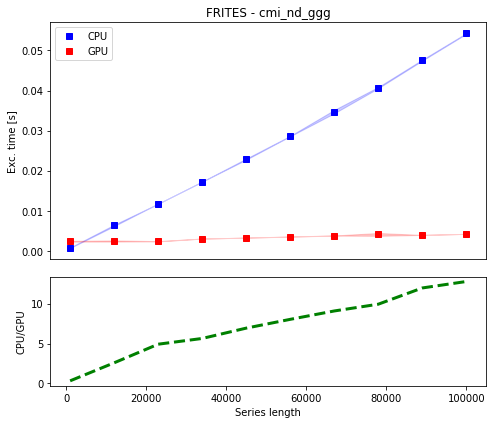

In [66]:
plt.figure(figsize=(7,6))
plt.subplot2grid((3,2), (0,0), rowspan = 2, colspan = 2)
plt.plot(N_arr, exta[0], 'sb', label = 'CPU')
plt.fill_between(N_arr, exta[0]-2*exts[0], exta[0]+2*exts[0], color = 'b', alpha = .2)
plt.plot(N_arr, exta[1], 'sr', label = 'GPU')
plt.fill_between(N_arr, exta[1]-2*exts[1], exta[1]+2*exts[1], color = 'r', alpha = .2)
plt.xticks([])
plt.title('FRITES - cmi_nd_ggg')
plt.ylabel('Exc. time [s]')
plt.legend()
plt.subplot2grid((3,2), (2,0), rowspan = 1, colspan = 2)
plt.plot(N_arr, exta[0]/exta[1], 'g--', lw = 3)
plt.ylabel(r'CPU/GPU')
plt.xlabel('Series length')
plt.tight_layout()
plt.savefig('cmi_nd_ggg.pdf', dpi = 600)